In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple
from PIL import Image

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip,RandomCrop, Input, LeakyReLU

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

seed = 1235
tf.random.set_seed(seed)

2024-12-01 18:45:03.438473: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 18:45:03.476585: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 18:45:04.118604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-12-01 18:17:29.255539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 18:17:29.298890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 18:17:29.299154: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Functions

In [3]:
def plot_metrics(model, *, names=['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc']):
    """
    Plot training and validation metrics from a model's training history.
    
    This function creates a figure with three subplots showing the progression of different
    metrics (loss, accuracy, and AUC) over training epochs. Each subplot displays both the
    training and validation metrics for easy comparison.
    
    Parameters
    ----------
    model : tf.keras.callbacks.History
        The history object returned by model.fit() containing the training metrics.
        Should have the specified metrics in its history dictionary.
    names : list of str, optional
        List of metric names to plot. Should contain 6 strings in the order:
        [training_loss, val_loss, training_acc, val_acc, training_auc, val_auc].
        Default is ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc'].
        
    Returns
    -------
    None
        The function displays the plot but doesn't return any values.
        
    Raises
    ------
    KeyError
        If any of the specified metric names are not found in model.history.
    ValueError
        If the names list doesn't contain exactly 6 metrics.
        
    Examples
    --------
    >>> history = model.fit(x_train, y_train, validation_data=(x_val, y_val))
    >>> plot_metrics(history)
    
    >>> # With custom metric names
    >>> plot_metrics(history, names=['loss', 'val_loss', 'binary_accuracy', 
                                   'val_binary_accuracy', 'auc', 'val_auc'])
    
    Notes
    -----
    - The function creates a 1x3 grid of subplots with the following arrangement:
        1. Loss metrics (left)
        2. Accuracy metrics (middle)
        3. AUC metrics (right)
    - Training metrics are plotted in teal
    - Validation metrics are plotted in orange
    - The figure is created with a size of 10x5 inches and 300 DPI
    """
    # Validate input
    if len(names) != 6:
        raise ValueError("Expected 6 metric names, got {len(names)}")
    
    # Pre-fetch all data at once to avoid multiple dictionary lookups
    try:
        metrics_data = {name: model.history[name] for name in names}
    except KeyError as e:
        raise KeyError(f"Metric {e} not found in model history. Available metrics: {list(model.history.keys())}")
    
    # Create figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=300)
    plt.suptitle('Performance Metrics', fontsize=15)
    
    # Define plot configurations
    plot_configs = [
        {'idx': 0, 'metrics': names[0:2], 'title': 'Loss', 'colors': ['teal', 'orange']},
        {'idx': 1, 'metrics': names[2:4], 'title': 'Accuracy', 'colors': ['teal', 'orange']},
        {'idx': 2, 'metrics': names[4:6], 'title': 'AUC', 'colors': ['teal', 'orange']}
    ]
    
    # Create plots using a loop
    for config in plot_configs:
        ax = axes[config['idx']]
        for metric, color in zip(config['metrics'], config['colors']):
            ax.plot(metrics_data[metric], color=color, label=metric)
        ax.set_title(config['title'], fontsize=10)
        ax.set_xlabel('Epochs')
        ax.legend(loc="upper left")
    
    plt.tight_layout()
    plt.show()

In [4]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, title="ROC Curve"):
    """
    Plots the ROC curve and computes the AUC.

    Parameters:
    - y_true: True labels (array-like, shape = [n_samples])
    - y_pred_prob: Predicted probabilities for the positive class (array-like, shape = [n_samples])
    - title: Title of the plot (default: "ROC Curve")
    """
    # Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    
    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Diagonal line for random guess
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [5]:
def get_lables(model, test):
    """
    Extracts the true labels and predictions from a model and test dataset.

    Args:
        model (tf.keras.Model): The trained TensorFlow/Keras model used for prediction.
        test (tf.data.Dataset): A test dataset containing images and labels, typically in batch format.

    Returns:
        tuple:
            - y_true (np.ndarray): A NumPy array containing the true labels for all samples in the test dataset.
            - y_pred (np.ndarray): A NumPy array containing the predicted labels (or probabilities) from the model.

    Notes:
        - This function processes the test dataset batch-by-batch, extracts the true labels, 
          and concatenates them into a single array.
        - Predictions are generated for the entire test dataset using the model's `predict` method.

    Example:
        ```
        # Assuming `model` is a trained Keras model and `test_dataset` is a tf.data.Dataset
        y_true, y_pred = get_labels(model, test_dataset)

        # Save the true labels as a NumPy file
        np.save('true_labels.npy', y_true)
        ```
    """
    
    y_pred = model.predict(test)
    
    test_data_list = list(test)
    labels = []
    for batch in test_data_list:
        images, label = batch
        # Process your batch here
        labels.append(label.numpy())
        #print(images.shape, labels.shape)
    y_true = np.concatenate(labels, axis=0)
    return y_true, y_pred
    
    #To save the numpy arrays
    #np.save('EFlow Images/Notebooks', y_true)

# 1. Data Augmentation

In [3]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img, save_img
# # Function to generate 5 crops and their horizontal flips
# def augment_image(image):
#     crops = []

#     # Original image shape should be (256, 256, 3)
#     height, width = image.shape[:2]

#     # Define the coordinates for the 5 crops
#     top_left = image[:224, :224]
#     top_right = image[:224, width-224:]
#     bottom_left = image[height-224:, :224]
#     bottom_right = image[height-224:, width-224:]
#     center = image[(height-224)//2:(height+224)//2, (width-224)//2:(width+224)//2]

#     # Collect the crops
#     crops.extend([top_left, top_right, bottom_left, bottom_right, center])

#     # Generate horizontal flips for each crop
#     flipped_crops = [np.fliplr(crop) for crop in crops]

#     # Combine original crops with flipped crops
#     all_crops = crops + flipped_crops

#     return all_crops

In [4]:
# # Directories for saving augmented images
# save_dir = '/teamspace/studios/this_studio/EFlow Images/AlexNet_augmentation'
# os.makedirs(save_dir, exist_ok=True)
# os.makedirs(os.path.join(save_dir,'background'), exist_ok=True) #background directory
# os.makedirs(os.path.join(save_dir,'signal'), exist_ok=True) #signal directory

In [5]:
# print(f'Current Working Directory: {os.getcwd()}')
# data_dir = '/teamspace/studios/this_studio/EFlow Images/data'

# for directory in os.listdir(data_dir):
#     print(f"Inside {directory}")
#     img_count = 0
#     for i, image_path in enumerate(os.listdir(os.path.join(data_dir,directory))):
#         image_path = os.path.join(data_dir,directory, image_path)
#         img = load_img(image_path)
#         img = img_to_array(img)

#         if i%500 == 0:
#             print(f'Loaded {i}th image succesfully...')

#         #Resize to 256x256 if necessary
#         img = tf.image.resize(img, [256, 256]).numpy()
    
#         # Generate 10 augmented images
#         augmented_images = augment_image(img)
    
#         # Save each augmented image with the corresponding label
#         for j, augmented_image in enumerate(augmented_images):
#             # Convert to PIL image
#             augmented_image = array_to_img(augmented_image)

#             save_image_name = f'{os.path.basename(image_path).split("/")[-1].split(".")[0]}_aug_{j}.png'
#             dest_path = os.path.join(save_dir, directory)
    
#             # Save the image
#             #augmented_image.save(dest_path, "PNG")
#             augmented_image.save(os.path.join(dest_path, save_image_name))

        
#         img_count +=1
        
#     print(f'Images processed inside {directory}: {img_count}')
# print('------Task Completed------')

In [6]:
# for img in os.listdir(os.path.join(data_dir,'signal')):
#     image_path = os.path.join(os.path.join(data_dir,'signal'),img)
#     image = Image.open(image_path)
#     image = np.array(image)
#     print(image.shape)

# 2. Loading the Dataset

Found 2415 files belonging to 2 classes.


2024-12-01 18:17:32.681032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 18:17:32.681294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 18:17:32.681434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

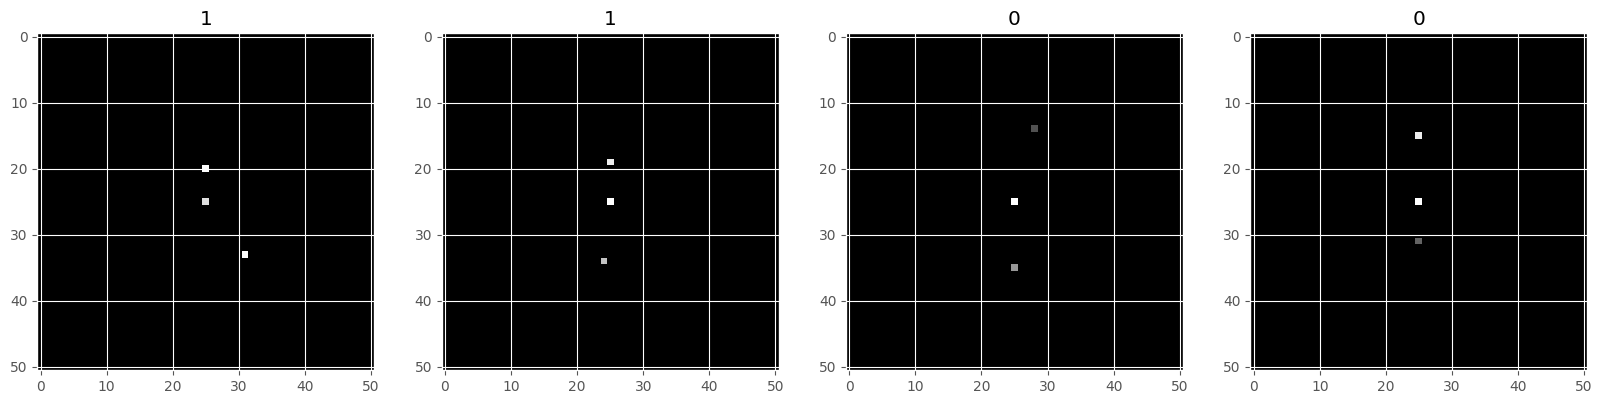

In [6]:
data_dir = '/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN/btagged_images'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 100,
                                                   color_mode = 'grayscale',
                                                   image_size = (51,51))

data = data.map(lambda x, y: (x/255, y))

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img, cmap = 'gray')
    ax[idx].title.set_text(batch[1][idx])

In [7]:
data_iterator.next()[0].shape

(100, 51, 51, 1)

## 2.1 Train-Test Split

In [8]:
train_size = int(len(data)*.7) #70% of total batches as training data
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. AlexNet Architecture

In [10]:
alex_net = Sequential()

alex_net.add(Conv2D(96, (6,6), 4, activation='relu', input_shape=(51,51,1)))
alex_net.add(MaxPooling2D((3,3), strides = 2))

alex_net.add(Conv2D(256, (3,3), strides = 1, activation='relu', padding = 'same'))
alex_net.add(MaxPooling2D((3,3), strides = 2))

alex_net.add(Conv2D(384, (3,3), 1, activation='relu', padding = 'same'))
alex_net.add(Conv2D(384, (3,3), 1, activation='relu', padding = 'same'))
alex_net.add(Conv2D(256, (3,3), 1, activation='relu', padding = 'same'))
alex_net.add(MaxPooling2D((2,2), strides = 2))

alex_net.add(Flatten())
alex_net.add(Dropout(0.5))
alex_net.add(Dense(4096, activation = 'relu'))
alex_net.add(Dropout(0.5))
alex_net.add(Dense(4096, activation = 'relu'))

#Output Layer
alex_net.add(Dense(1, activation = 'sigmoid'))

alex_net.summary()

#(W-2F+P/S) +1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 12, 12, 96)     │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 5, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 5, 5, 256)      │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,160,673 (80.72 MB)

 Trainable params: 21,160,673 (80.72 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Training the Model

In [11]:
alex_net.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

logdir = '/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN/alex_net_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_callback = ModelCheckpoint(
    filepath='alex_netClassifier.keras',
    save_weights_only=False,
    monitor='val_auc',              
    mode='auto',           
    save_best_only=True,
    verbose=2
)


alex_net_hist = alex_net.fit(train,
                 epochs = 10,
                 validation_data = val, 
                 callbacks = [tensorboard_callback, checkpoint_callback])

Epoch 1/10


I0000 00:00:1733043533.336238   17032 service.cc:145] XLA service 0x7fb6a0005dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733043533.336278   17032 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-12-01 08:58:53.466924: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-01 08:58:53.819856: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1733043540.296467   17032 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6038 - auc: 0.4825 - false_negatives: 235.3571 - false_positives: 51.0000 - loss: 0.6739 - precision: 0.4000 - recall: 0.2228 - true_negatives: 429.6429 - true_positives: 34.0000
Epoch 1: val_auc improved from inf to 0.67751, saving model to alex_netClassifier.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.6074 - auc: 0.4853 - false_negatives: 308.8889 - false_positives: 51.0000 - loss: 0.6724 - precision: 0.4000 - recall: 0.1859 - true_negatives: 550.5555 - true_positives: 34.0000 - val_accuracy: 0.6000 - val_auc: 0.6775 - val_false_negatives: 200.0000 - val_false_positives: 0.0000e+00 - val_loss: 0.6614 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_negatives: 300.0000 - val_true_positives: 0.0000e+00
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6205 - auc: 0.6342 - false_negatives: 334.8235 - false_positives: 2.1765 - loss: 0.6374 - precision: 0.1759 - recall: 0.0027 - true_nega

# 5. Testing

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7667 - auc: 0.8424 - false_negatives: 29.6667 - false_positives: 9.6667 - loss: 0.4983 - precision: 0.7905 - recall: 0.5468 - true_negatives: 91.3333 - true_positives: 36.0000


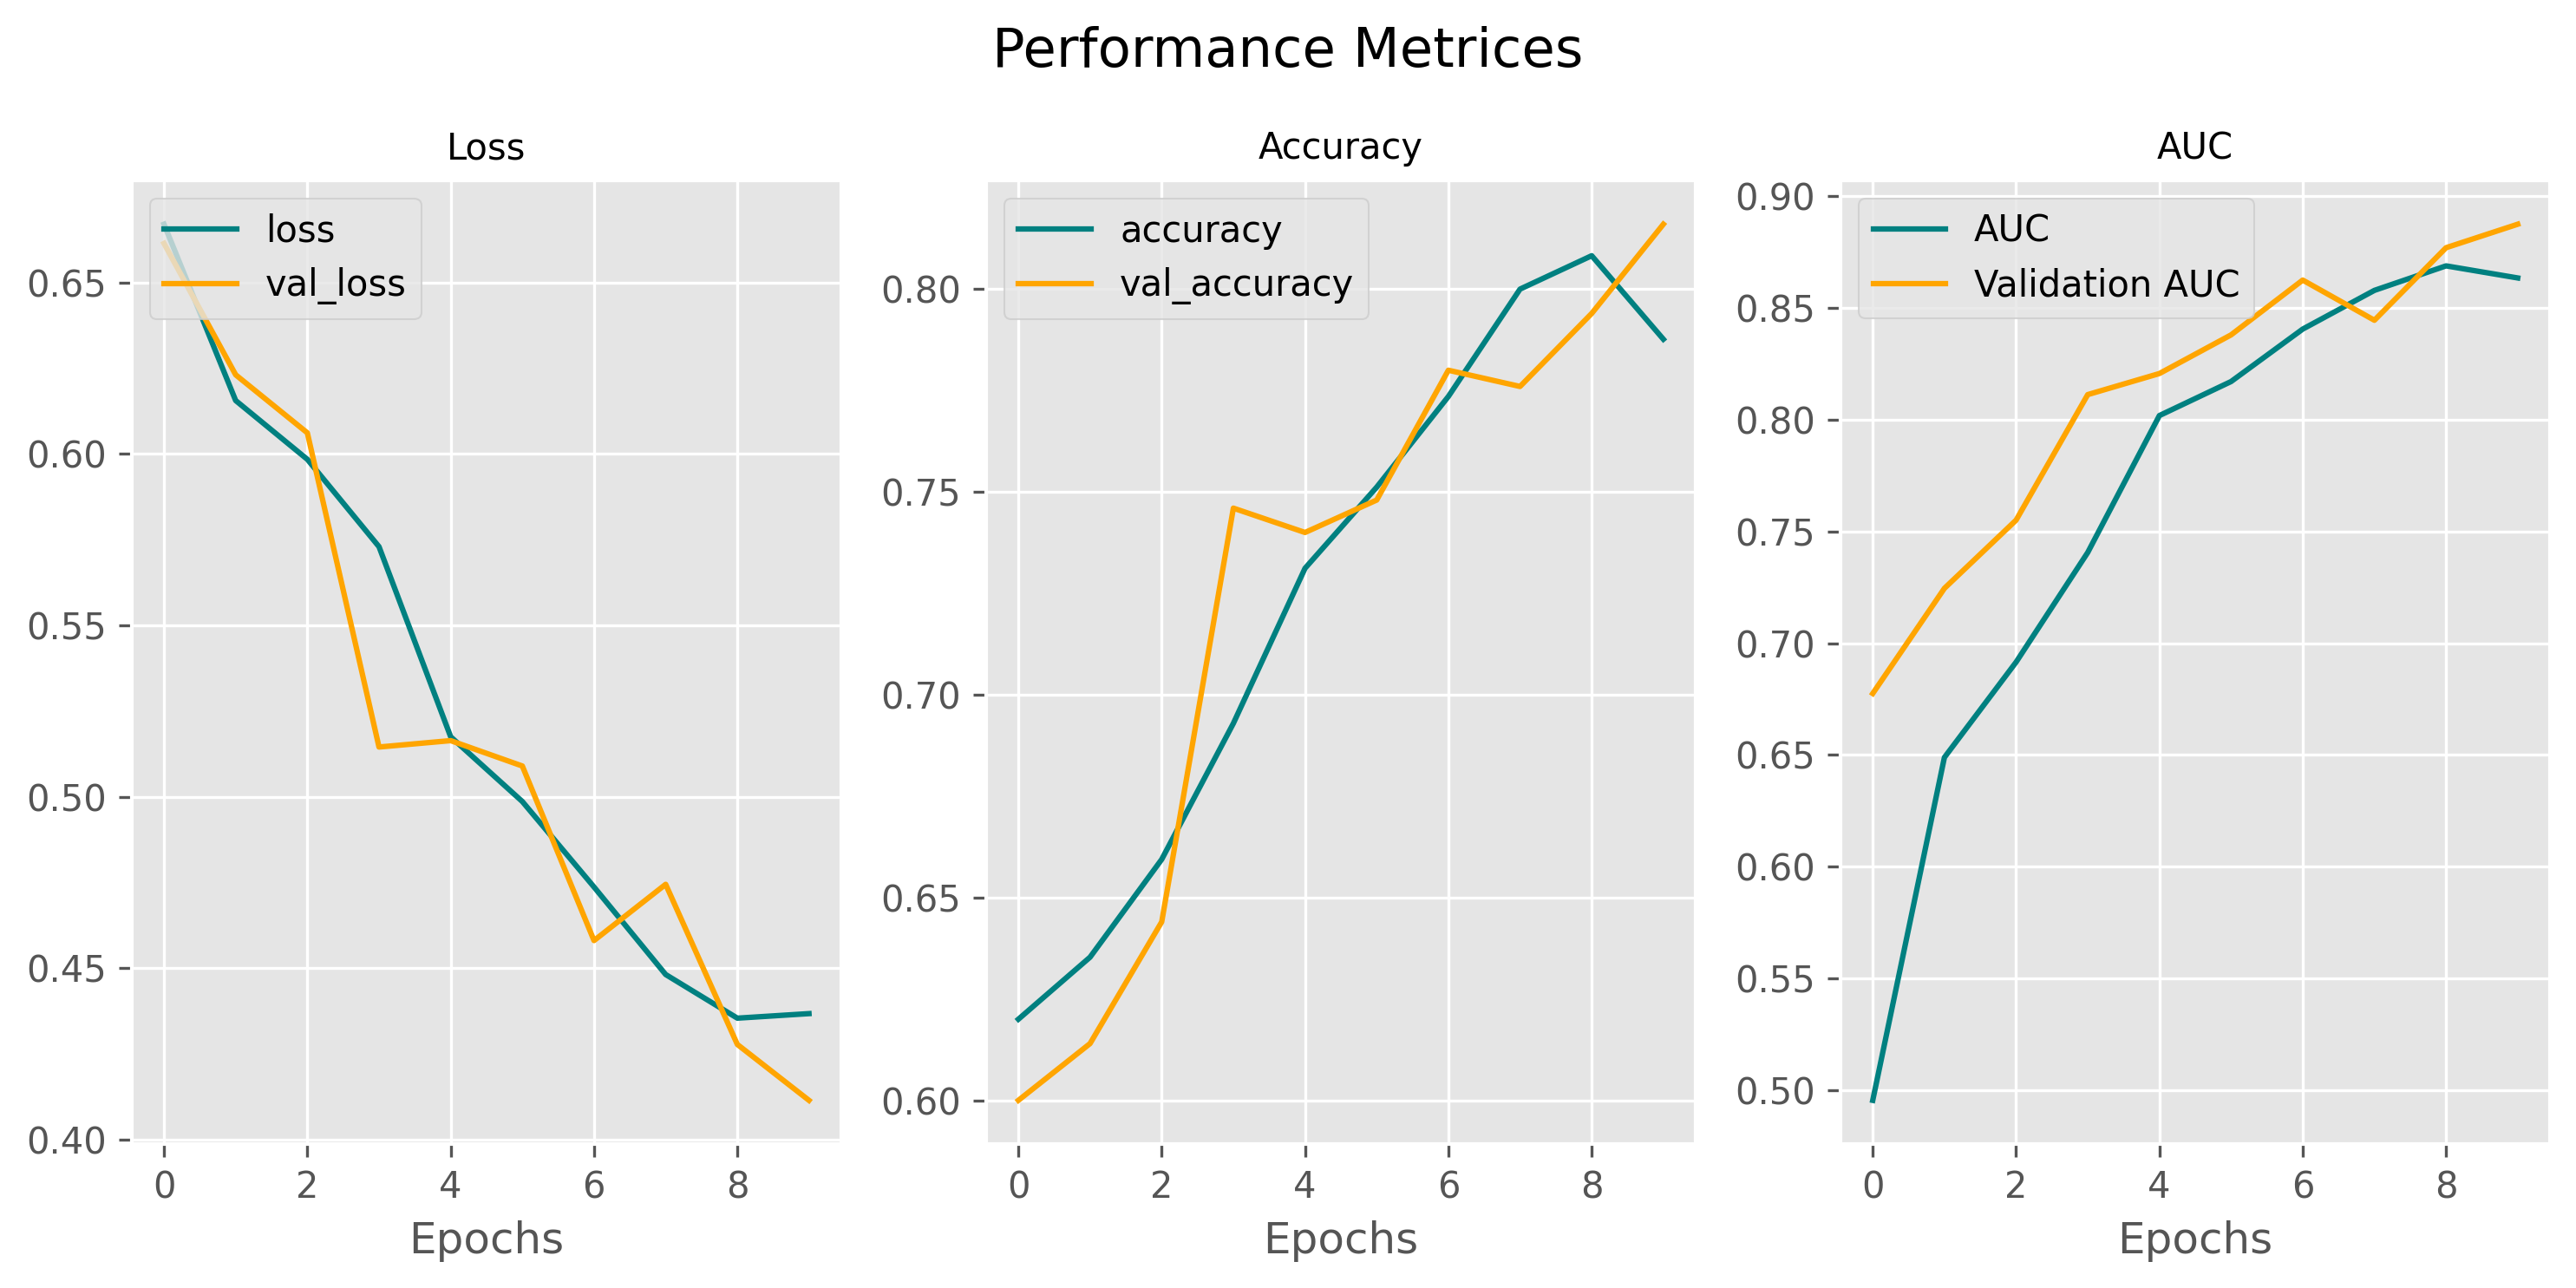

In [13]:
eval_metrices = alex_net.evaluate(test)
plot_metrices(alex_net_hist, names = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc', 'val_auc'])

# 6. Predictions

In [15]:
y_true, y_pred = get_lables(alex_net, test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


2024-12-01 08:59:08.799487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# 7. ROC Curve

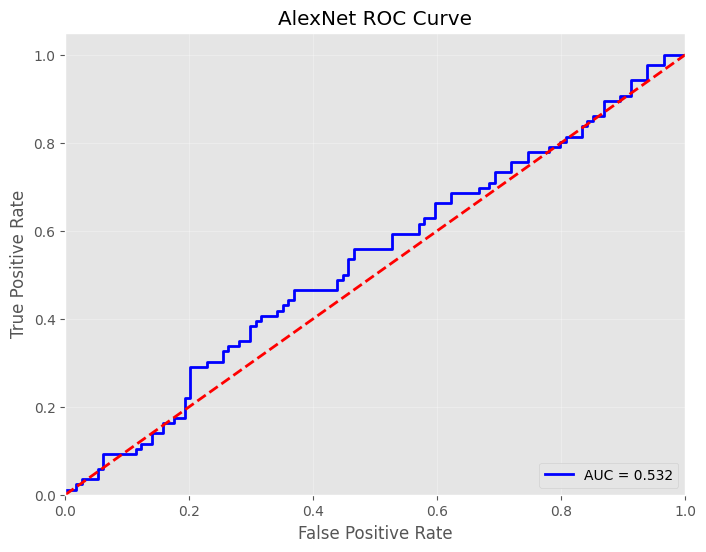

In [17]:
plot_roc_curve(y_true, y_pred, title = 'AlexNet ROC Curve')


# Model 2

In [18]:
model2 = Sequential()

model2.add(Conv2D(128, (3,3), 1, activation='relu', input_shape=(51,51,1)))
model2.add(MaxPooling2D(strides=1)) #2x2 filter

model2.add(Conv2D(64, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(32, (3,3), 1, activation='relu'))
model2.add(MaxPooling2D(strides=1,
                        padding='same'))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     3,612,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,721 (14.14 MB)

 Trainable params: 3,706,721 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model2.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

logdir = '/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN/model2_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_callback = ModelCheckpoint(
    filepath='model2.keras',
    save_weights_only=False,
    monitor='val_auc',              
    mode='auto',           
    save_best_only=True,
    verbose=2
)


model2_hist = model2.fit(train,
                 epochs = 10,
                 validation_data = val, 
                 callbacks = [tensorboard_callback, checkpoint_callback])

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.6404 - auc_1: 0.5977 - false_negatives_1: 276.0000 - false_positives_1: 46.6111 - loss: 0.6391 - precision_1: 0.4950 - recall_1: 0.1458 - true_negatives_1: 558.3889 - true_positives_1: 63.4444 - val_accuracy: 0.7440 - val_auc_1: 0.8126 - val_false_negatives_1: 82.0000 - val_false_positives_1: 46.0000 - val_loss: 0.5158 - val_precision_1: 0.6871 - val_recall_1: 0.5519 - val_true_negatives_1: 271.0000 - val_true_positives_1: 101.0000
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7325 - auc_1: 0.7674 - false_negatives_1: 157.3889 - false_positives_1: 97.2778 - loss: 0.5522 - precision_1: 0.6715 - recall_1: 0.5176 - true_negatives_1: 509.5000 - true_positives_1: 180.2778 - val_accuracy: 0.6960 - val_auc_1: 0.7641 - val_false_negatives_1: 120.0000 - val_false_positives_1: 32.0000 - val_loss: 0.6073 - val_precision_1: 0.7143 - val_recall_1: 0.4000 - val_true_negatives_1: 268.0000 - val_true_positives_1: 80.0

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8667 - auc_1: 0.9028 - false_negatives_1: 14.0000 - false_positives_1: 8.6667 - loss: 0.4130 - precision_1: 0.8699 - recall_1: 0.8000 - true_negatives_1: 88.3333 - true_positives_1: 55.6667


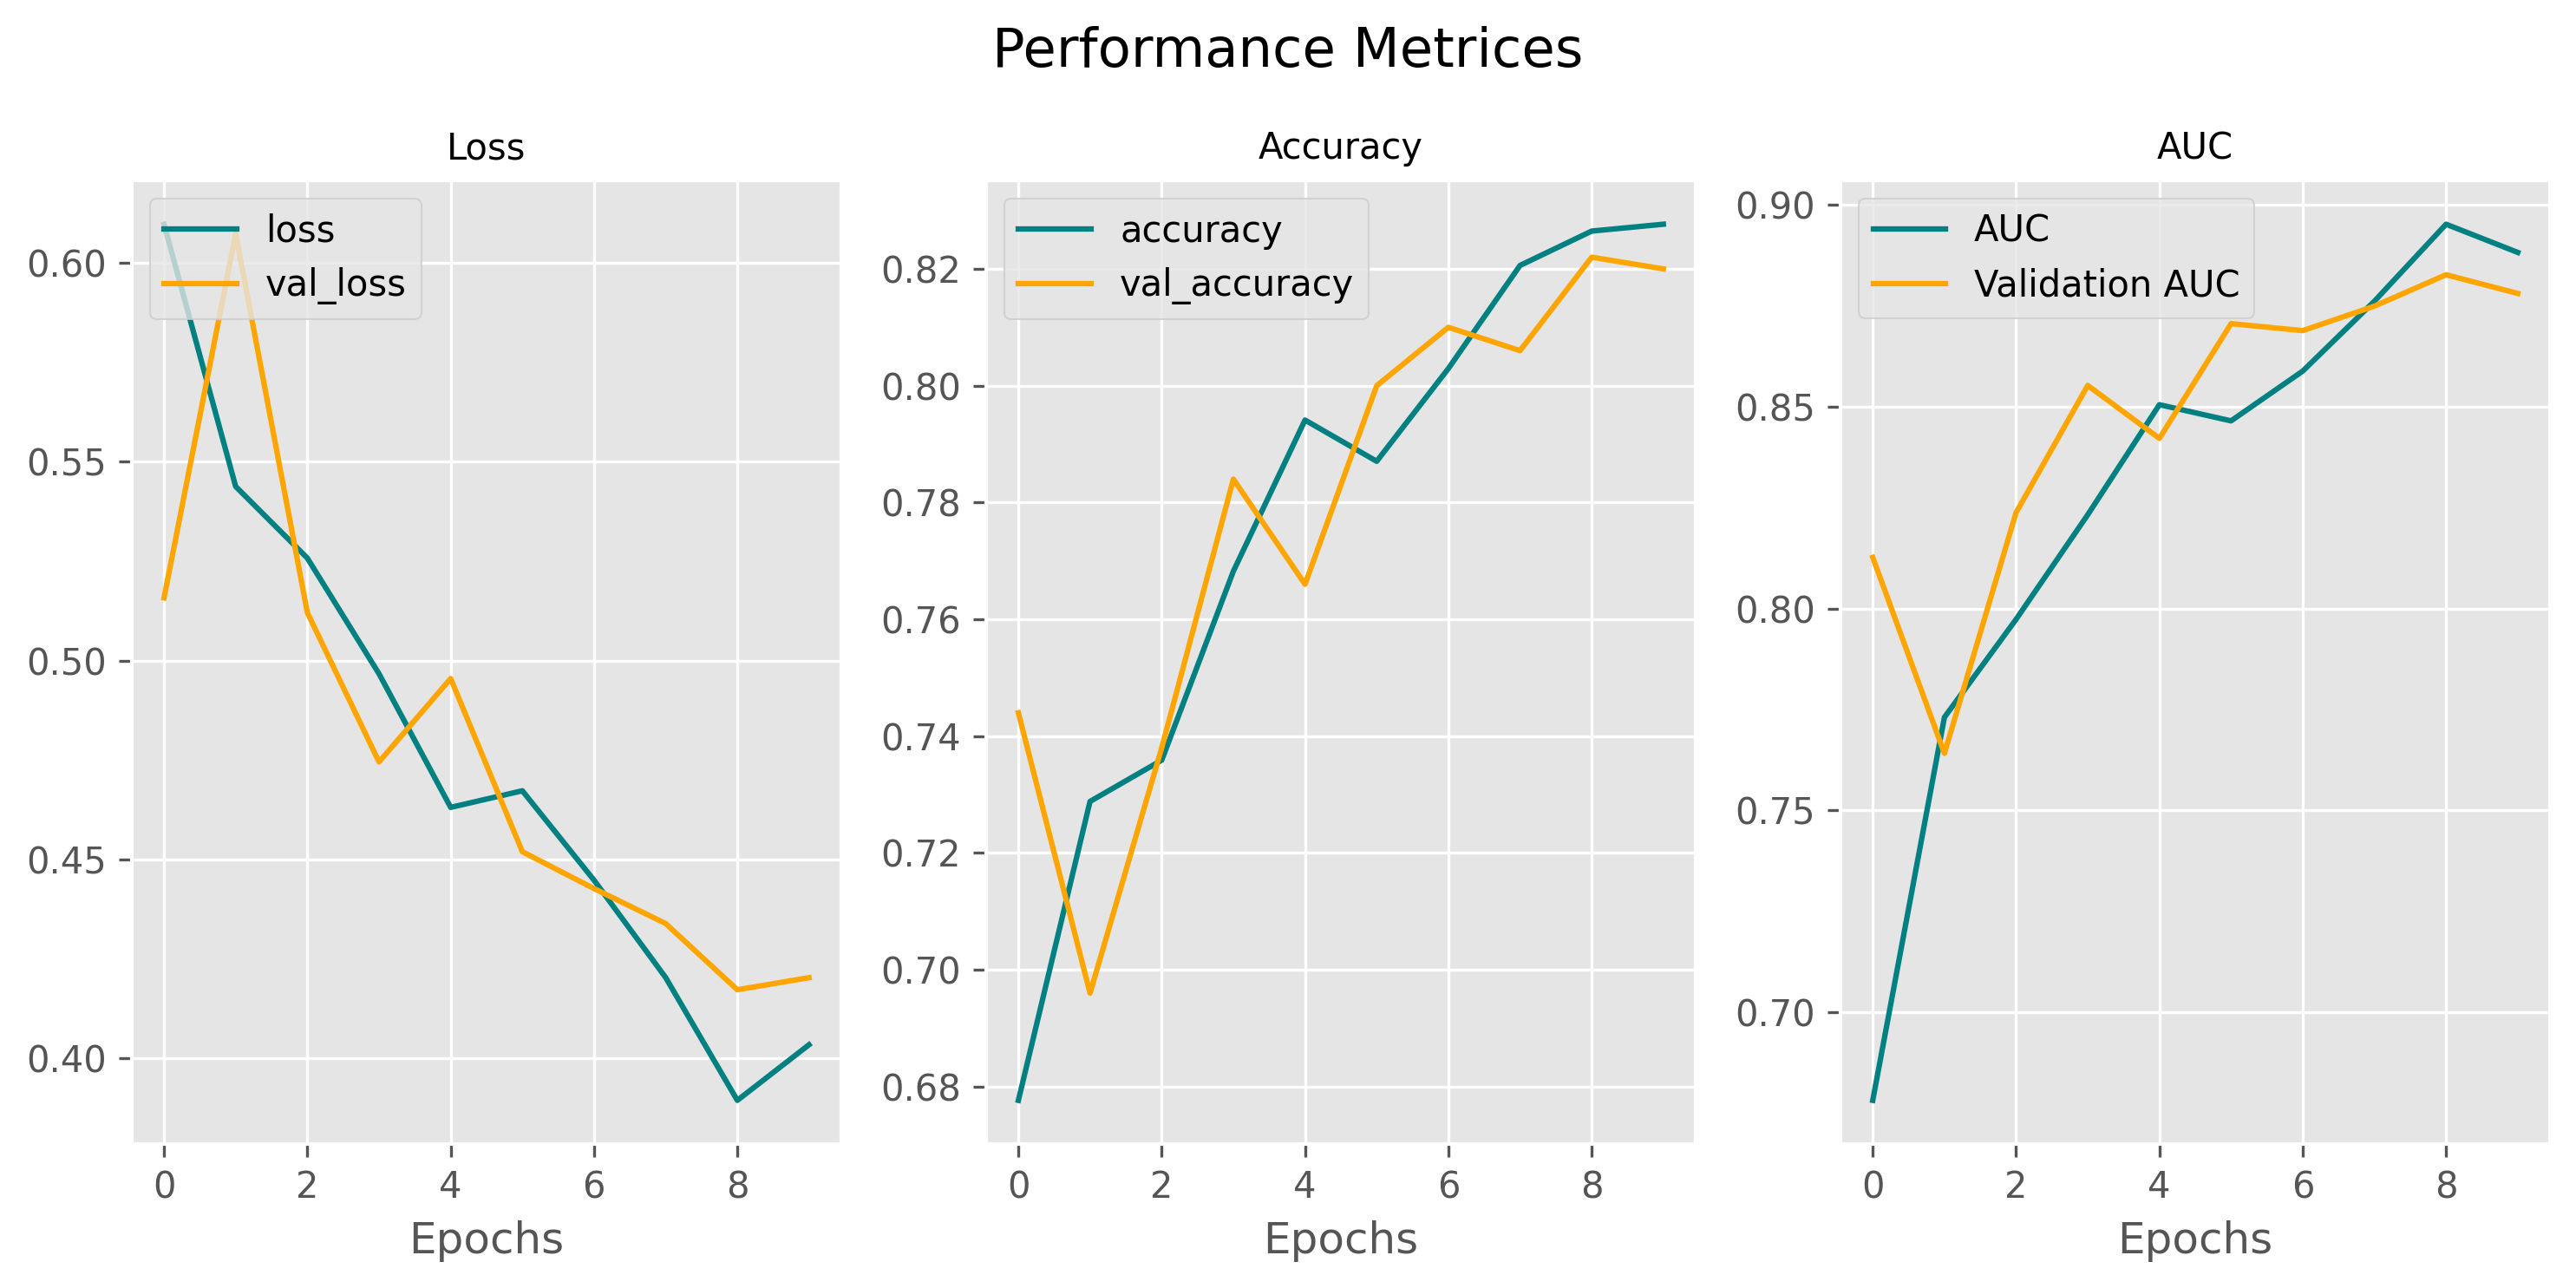

In [20]:
model2_eval_metrices = model2.evaluate(test)
plot_metrices(model2_hist, names = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc_1', 'val_auc_1'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


2024-12-01 08:59:26.386500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


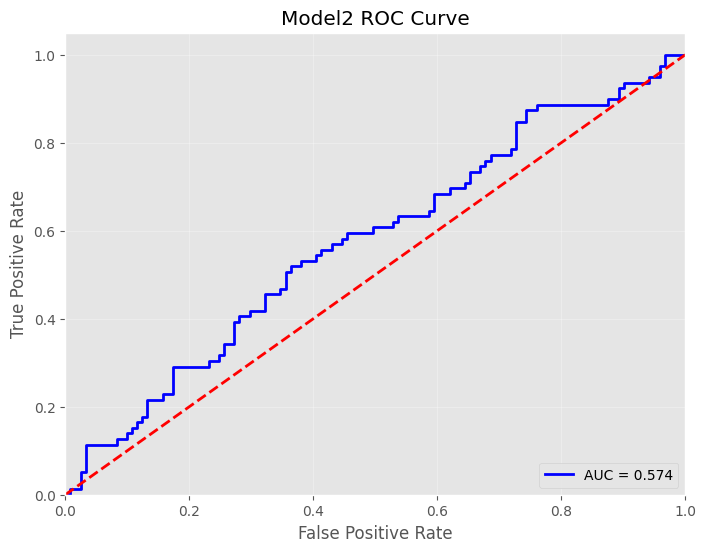

In [21]:
y_true, y_pred = get_lables(model2, test)
plot_roc_curve(y_true, y_pred, title = 'Model2 ROC Curve')

# Model 3: Single Convolution Layer Network

In [47]:
model3 = Sequential()

model3.add(Input(shape=(51, 51, 1)))
model3.add(Conv2D(128, (5,5), 1))
model3.add(tf.keras.layers.LeakyReLU(negative_slope = 0))
model3.add(MaxPooling2D(strides=1)) #2x2 filter

model3.add(Flatten())

model3.add(Dense(256, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 47, 47, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 47, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 270848)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    69,337,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,340,929 (264.51 MB)

 Trainable params: 69,340,929 (264.51 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model3.compile('adam', 
              loss=tf.losses.BinaryCrossentropy(), 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives()])

logdir = '/teamspace/studios/this_studio/EFlow Images/btagged_images_CNN/model3_logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_callback = ModelCheckpoint(
    filepath='model3.keras',
    save_weights_only=False,
    monitor='val_auc',              
    mode='auto',           
    save_best_only=True,
    verbose=2
)


model3_hist = model3.fit(train,
                 epochs = 10,
                 validation_data = val, 
                 callbacks = [tensorboard_callback, checkpoint_callback])

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.6362 - auc_10: 0.6247 - false_negatives_10: 204.8889 - false_positives_10: 120.5556 - loss: 0.6411 - precision_10: 0.4982 - recall_10: 0.3832 - true_negatives_10: 487.3333 - true_positives_10: 131.6667 - val_accuracy: 0.7140 - val_auc_10: 0.7658 - val_false_negatives_10: 63.0000 - val_false_positives_10: 80.0000 - val_loss: 0.5708 - val_precision_10: 0.6209 - val_recall_10: 0.6753 - val_true_negatives_10: 226.0000 - val_true_positives_10: 131.0000
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7365 - auc_10: 0.7987 - false_negatives_10: 142.2778 - false_positives_10: 106.1667 - loss: 0.5143 - precision_10: 0.6432 - recall_10: 0.5909 - true_negatives_10: 503.7778 - true_positives_10: 192.2222 - val_accuracy: 0.7600 - val_auc_10: 0.8197 - val_false_negatives_10: 70.0000 - val_false_positives_10: 50.0000 - val_loss: 0.4948 - val_precision_10: 0.6795 - val_recall_10: 0.6023 - val_true_negatives_10: 274.0000

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


2024-12-01 18:35:35.644036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


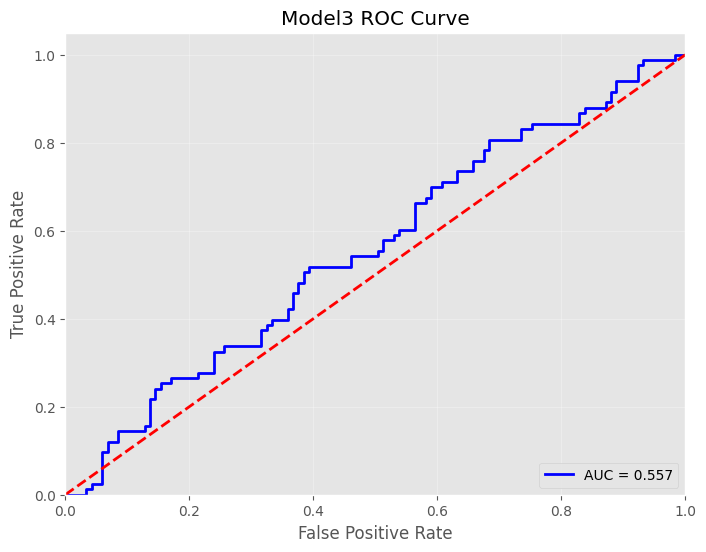

In [49]:
y_true, y_pred = get_lables(model3, test)
plot_roc_curve(y_true, y_pred, title = 'Model3 ROC Curve')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8767 - auc_10: 0.9334 - false_negatives_10: 13.0000 - false_positives_10: 8.0000 - loss: 0.3322 - precision_10: 0.8618 - recall_10: 0.8081 - true_negatives_10: 95.0000 - true_positives_10: 50.6667


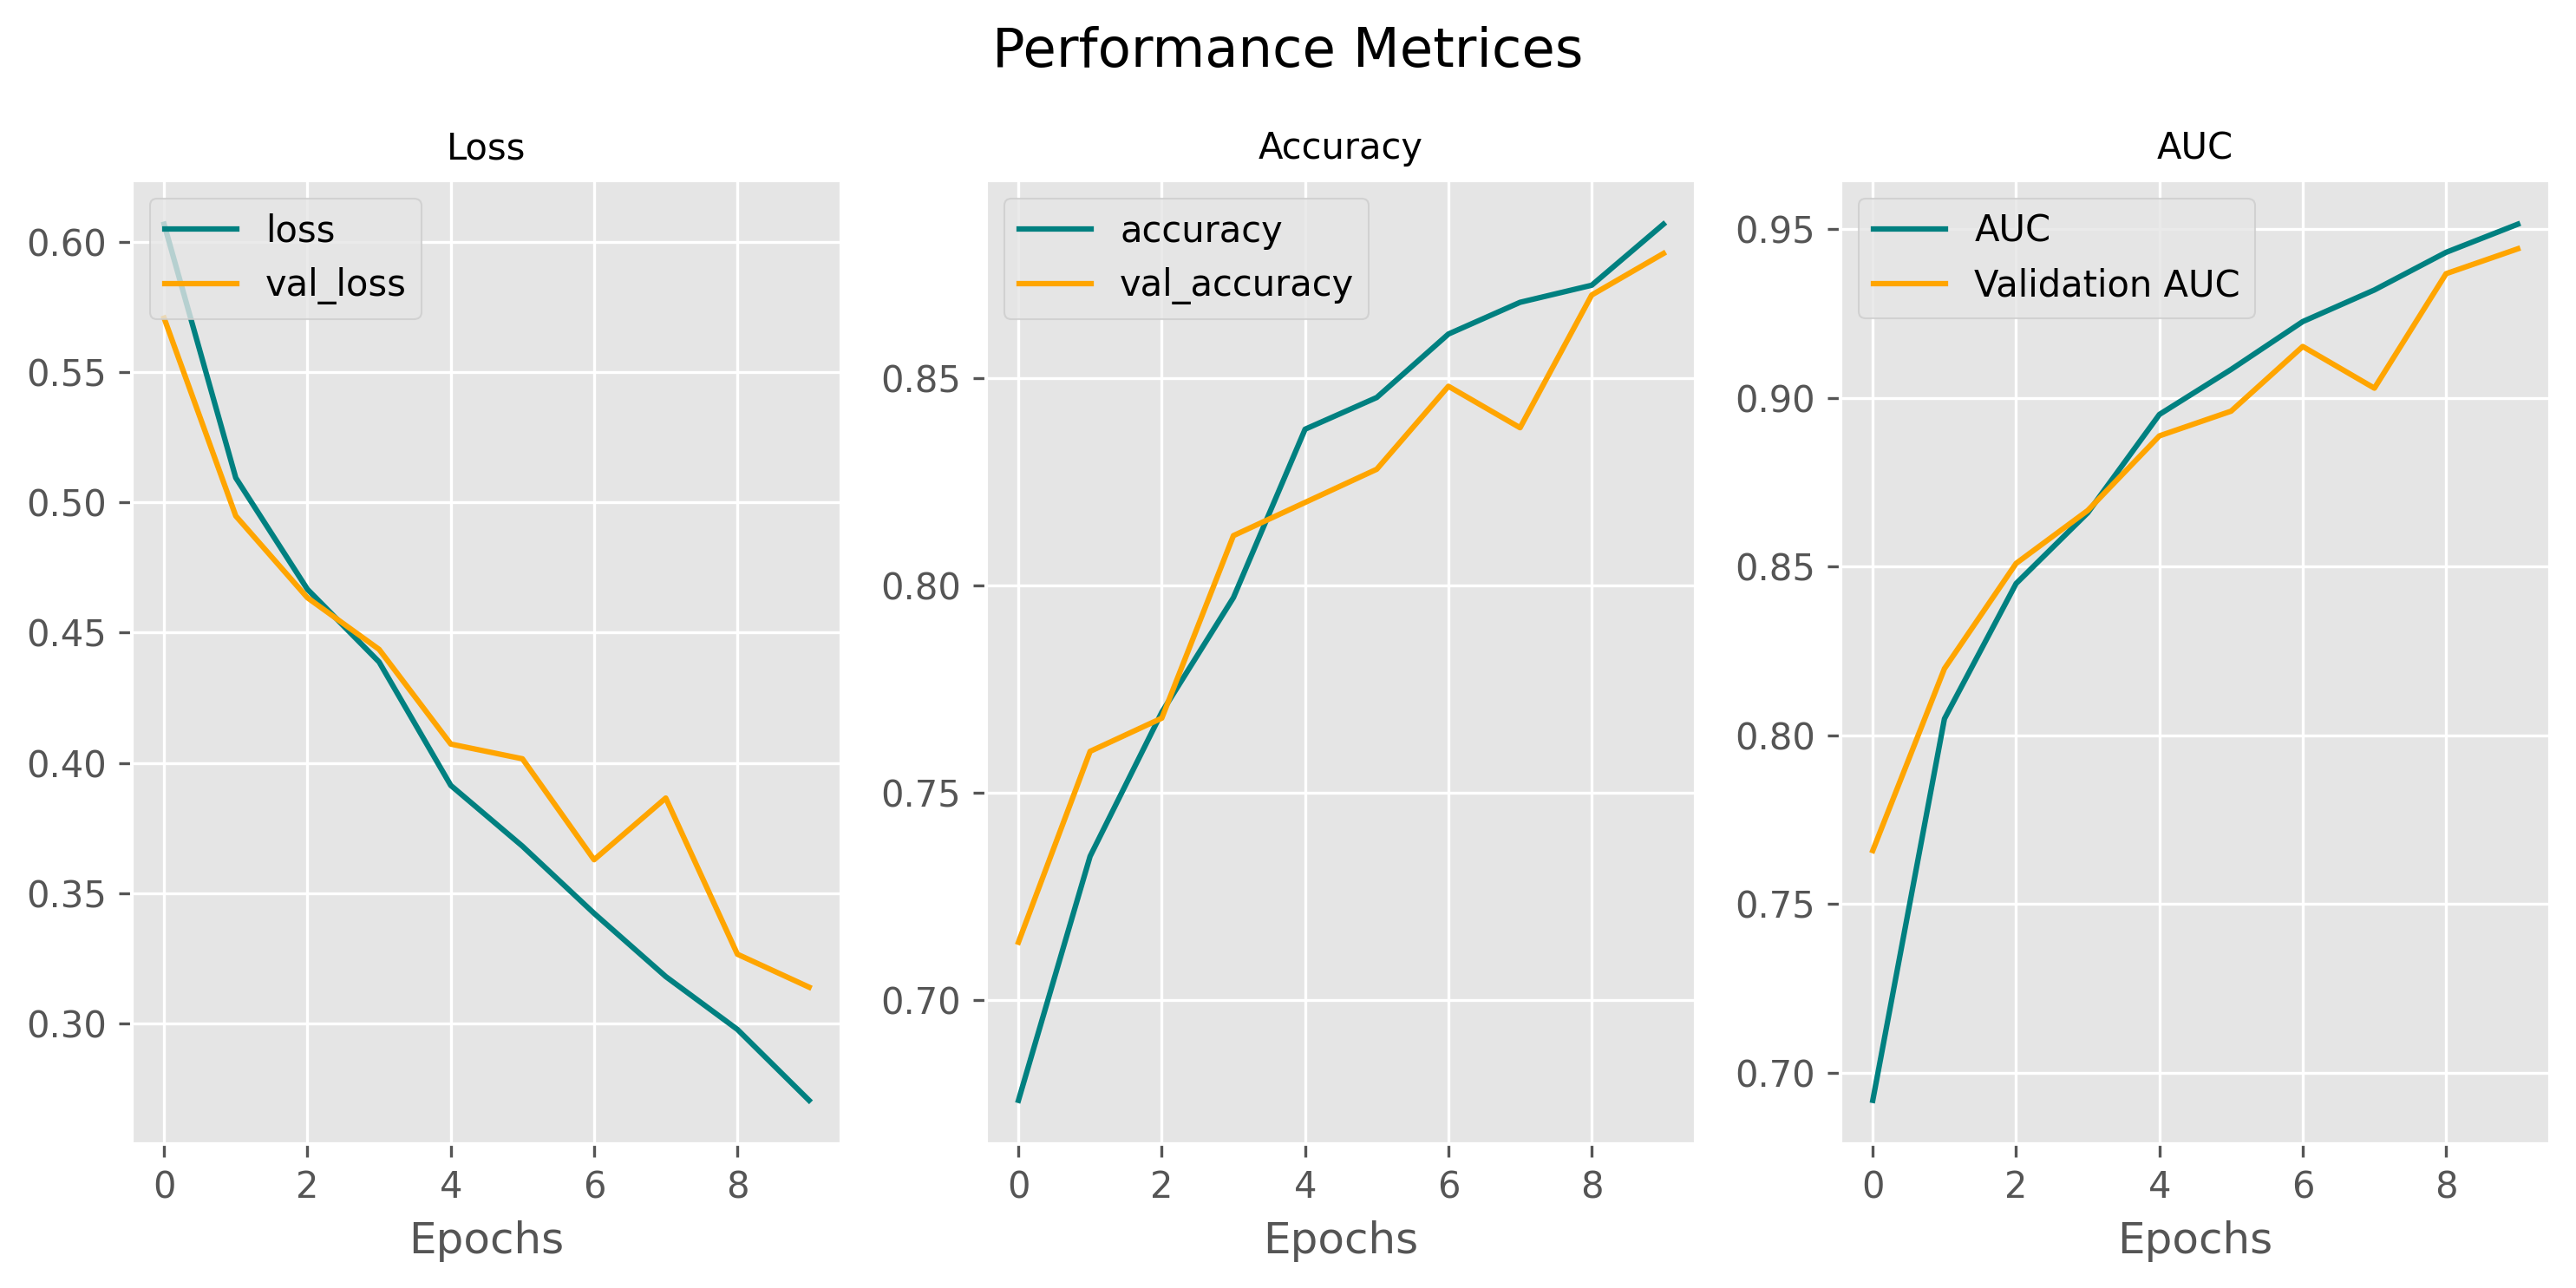

In [50]:
model3_eval_metrices = model3.evaluate(test)
plot_metrices(model3_hist, names = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'auc_10', 'val_auc_10'])